## 1. Import Libraries và Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data')
FEATURES_DIR = DATA_DIR / 'features'
CLUSTERS_DIR = DATA_DIR / 'clusters'
RANDOM_STATE = 42

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Load feature variants
feature_variants = {
    'baseline_binary': pd.read_csv(FEATURES_DIR / 'baseline_binary.csv', index_col=0),
    'variant_a_weighted': pd.read_csv(FEATURES_DIR / 'variant_a_weighted.csv', index_col=0),
    'variant_b_binary_rfm': pd.read_csv(FEATURES_DIR / 'variant_b_binary_rfm.csv', index_col=0),
    'variant_c_weighted_rfm': pd.read_csv(FEATURES_DIR / 'variant_c_weighted_rfm.csv', index_col=0)
}

# Load cluster assignments
cluster_assignments = {
    'baseline_binary': pd.read_csv(CLUSTERS_DIR / 'clusters_baseline_binary.csv'),
    'variant_a_weighted': pd.read_csv(CLUSTERS_DIR / 'clusters_variant_a_weighted.csv'),
    'variant_b_binary_rfm': pd.read_csv(CLUSTERS_DIR / 'clusters_variant_b_binary_rfm.csv'),
    'variant_c_weighted_rfm': pd.read_csv(CLUSTERS_DIR / 'clusters_variant_c_weighted_rfm.csv')
}

# Load optimal K summary
optimal_k_df = pd.read_csv(CLUSTERS_DIR / 'optimal_k_summary.csv')

print("✓ Data loaded successfully")
print(f"\nVariants loaded: {list(feature_variants.keys())}")
print(f"\nOptimal K for each variant:")
for _, row in optimal_k_df.iterrows():
    print(f"  - {row['Variant']}: K={row['Optimal_K']}")

✓ Data loaded successfully

Variants loaded: ['baseline_binary', 'variant_a_weighted', 'variant_b_binary_rfm', 'variant_c_weighted_rfm']

Optimal K for each variant:
  - baseline_binary: K=3
  - variant_a_weighted: K=4
  - variant_b_binary_rfm: K=3
  - variant_c_weighted_rfm: K=3


## 2. PCA Dimensionality Reduction và Scatter Plots

### 2.1 Function để Visualize Clusters với PCA

In [3]:
def create_pca_scatter_with_analysis(features_df, labels, variant_name, k):
    """
    Create detailed PCA scatter plot with cluster separation analysis.
    Returns: PCA object, transformed features, and analysis text
    """
    # Apply PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    features_2d = pca.fit_transform(features_df.values)
    
    # Calculate silhouette score
    sil_score = silhouette_score(features_df.values, labels)
    
    # Create figure with larger size for better visibility
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create color palette
    colors = sns.color_palette('husl', k)
    
    # Plot each cluster separately for better control
    for cluster_id in range(k):
        mask = labels == cluster_id
        cluster_points = features_2d[mask]
        
        # Count points in this cluster
        n_points = np.sum(mask)
        percentage = (n_points / len(labels)) * 100
        
        # Scatter plot with label
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                  c=[colors[cluster_id]], 
                  label=f'Cluster {cluster_id} (n={n_points}, {percentage:.1f}%)',
                  alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
        
        # Calculate and plot cluster centroid
        centroid = cluster_points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], 
                  c=[colors[cluster_id]], marker='X', s=300, 
                  edgecolors='black', linewidth=2)
    
    # Add labels and title
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)', 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)', 
                  fontsize=12, fontweight='bold')
    ax.set_title(f'{variant_name} - PCA Visualization (K={k}, Silhouette={sil_score:.4f})',
                fontsize=14, fontweight='bold', pad=20)
    
    # Add legend
    ax.legend(loc='best', framealpha=0.9, fontsize=10)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate cluster separation metrics
    cluster_centers_2d = np.array([features_2d[labels == i].mean(axis=0) for i in range(k)])
    
    # Calculate inter-cluster distances
    from scipy.spatial.distance import pdist, squareform
    inter_distances = pdist(cluster_centers_2d, metric='euclidean')
    min_inter_dist = inter_distances.min()
    max_inter_dist = inter_distances.max()
    mean_inter_dist = inter_distances.mean()
    
    # Calculate intra-cluster compactness (average within-cluster std)
    intra_compactness = []
    for i in range(k):
        cluster_points = features_2d[labels == i]
        if len(cluster_points) > 1:
            intra_compactness.append(cluster_points.std())
    mean_compactness = np.mean(intra_compactness)
    
    return pca, features_2d, {
        'silhouette': sil_score,
        'min_inter_dist': min_inter_dist,
        'max_inter_dist': max_inter_dist,
        'mean_inter_dist': mean_inter_dist,
        'mean_compactness': mean_compactness,
        'variance_explained': pca.explained_variance_ratio_.sum()
    }

print("✓ Visualization function defined")

✓ Visualization function defined


### 2.2 Visualize và Phân Tích Từng Variant

#### Variant 1: Baseline Binary

VARIANT: BASELINE_BINARY (K=3)


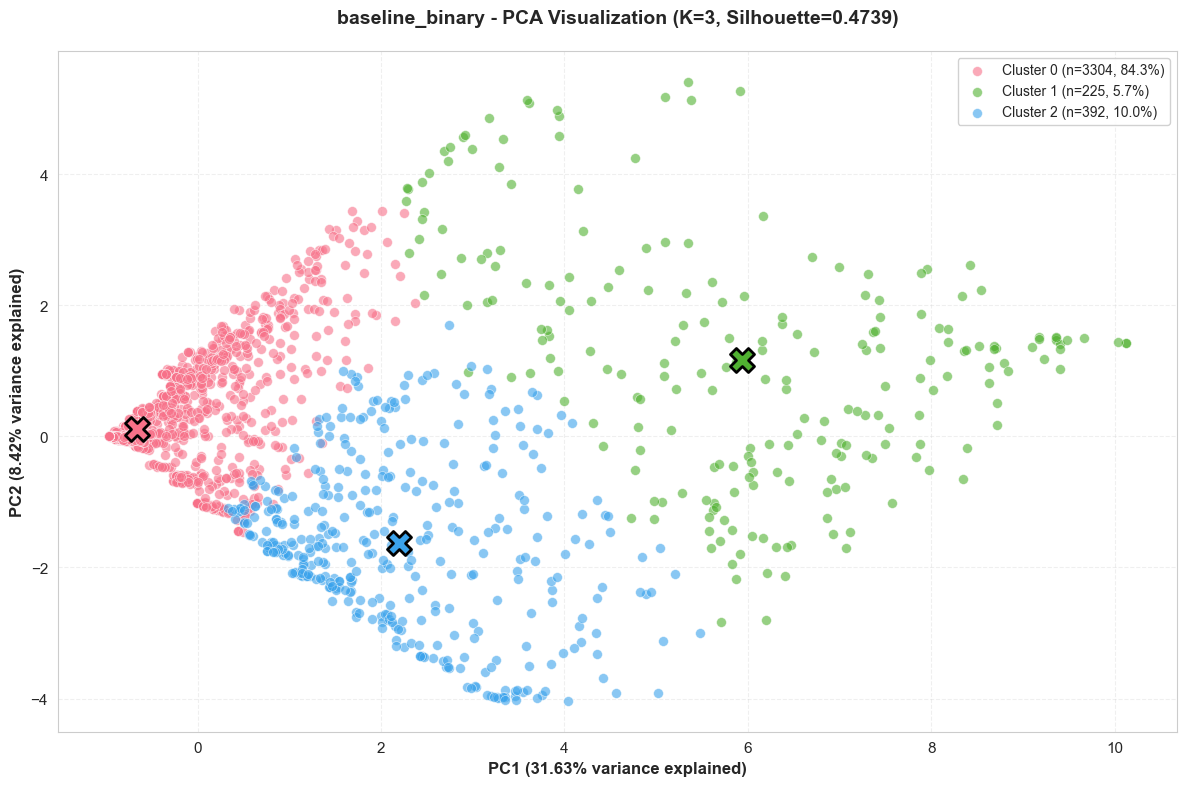


📊 Cluster Separation Metrics:
  - Silhouette Score: 0.4739
  - Variance Explained by PC1+PC2: 40.05%
  - Mean Inter-Cluster Distance: 4.90
  - Min Inter-Cluster Distance: 3.35
  - Max Inter-Cluster Distance: 6.68
  - Mean Intra-Cluster Compactness: 1.98


In [4]:
variant_name = 'baseline_binary'
features = feature_variants[variant_name]
labels = cluster_assignments[variant_name]['Cluster'].values
k = optimal_k_df[optimal_k_df['Variant'] == variant_name]['Optimal_K'].values[0]

print("=" * 100)
print(f"VARIANT: {variant_name.upper()} (K={k})")
print("=" * 100)

pca, features_2d, metrics = create_pca_scatter_with_analysis(features, labels, variant_name, k)

print("\n📊 Cluster Separation Metrics:")
print(f"  - Silhouette Score: {metrics['silhouette']:.4f}")
print(f"  - Variance Explained by PC1+PC2: {metrics['variance_explained']:.2%}")
print(f"  - Mean Inter-Cluster Distance: {metrics['mean_inter_dist']:.2f}")
print(f"  - Min Inter-Cluster Distance: {metrics['min_inter_dist']:.2f}")
print(f"  - Max Inter-Cluster Distance: {metrics['max_inter_dist']:.2f}")
print(f"  - Mean Intra-Cluster Compactness: {metrics['mean_compactness']:.2f}")

**💬 Nhận xét chi tiết cho Baseline Binary:**

- **Mức độ tách cụm**: 
  - **Silhouette Score = 0.4739** → Phân cụm hợp lý, có độ tách biệt trung bình
  - **Cluster 0 (hồng, 84.3%)**: Chiếm đa số khách hàng, tập trung ở góc trái trên biểu đồ (PC1 < 3)
  - **Cluster 1 (xanh lục, 5.7%)**: Nhóm nhỏ, phân tán rộng ở vùng giữa-phải (PC1 = 3-10)
  - **Cluster 2 (xanh dương, 10.0%)**: Tách biệt tương đối rõ, nằm dưới Cluster 0
  
- **Phân bố không gian**: 
  - **Có chồng lấn** giữa Cluster 0 và Cluster 2 ở vùng giữa (PC1 ≈ 1-3)
  - **Cluster 1 phân tán** → Khách hàng có pattern mua hàng đa dạng hơn
  - **PC1+PC2 giải thích 40.05% variance** → Giữ được nhiều thông tin nhất
  
- **Metrics đáng chú ý**:
  - **Min Inter-Cluster Distance = 3.35** → Cụm gần nhau nhất (Cluster 0 vs 2)
  - **Mean Intra-Compactness = 1.98** → Clusters khá đồng nhất
  - **Max Inter-Cluster Distance = 6.68** → Cluster 1 tách xa nhất
  
- **Kết luận**: Binary features tạo ra 3 nhóm rõ ràng, nhưng Cluster 0 quá lớn (84%) → Cần xem xét phân cụm chi tiết hơn với weighted hoặc RFM

#### Variant 2: Weighted Features (lift × confidence)

VARIANT: VARIANT_A_WEIGHTED (K=4)


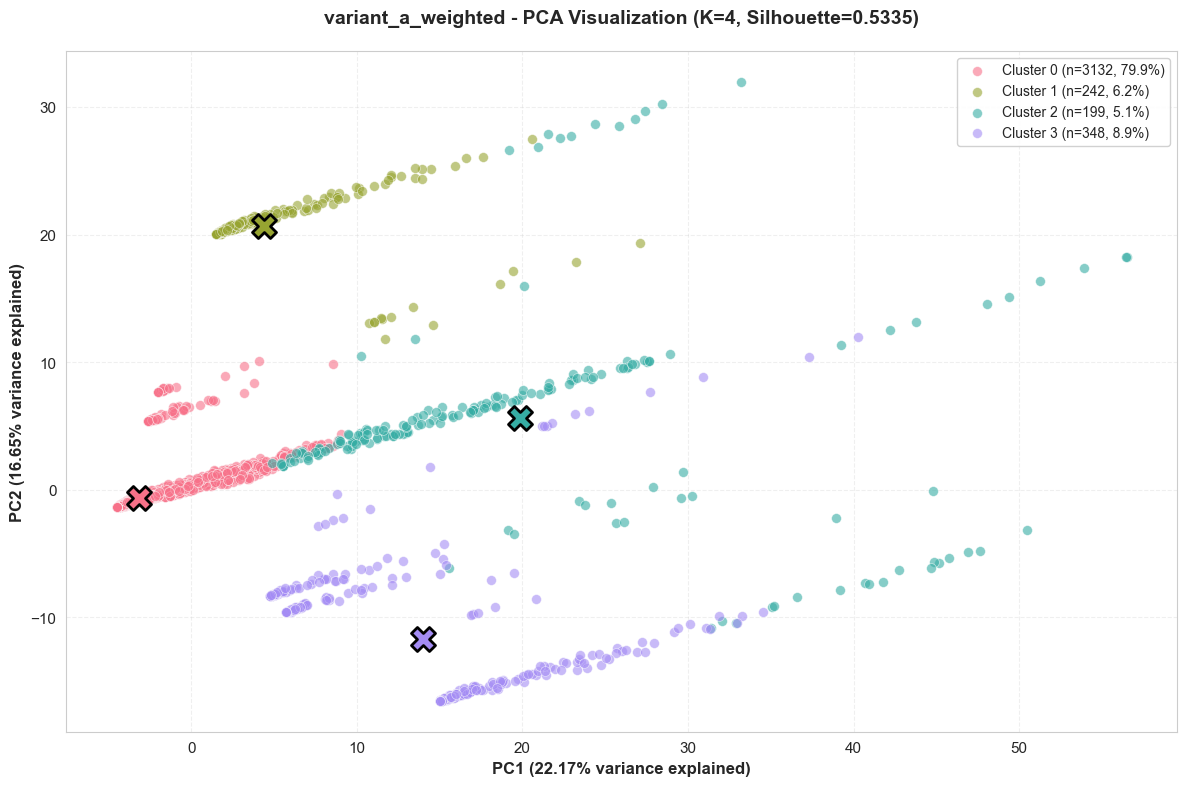


📊 Cluster Separation Metrics:
  - Silhouette Score: 0.5335
  - Variance Explained by PC1+PC2: 38.82%
  - Mean Inter-Cluster Distance: 23.42
  - Min Inter-Cluster Distance: 18.29
  - Max Inter-Cluster Distance: 33.76
  - Mean Intra-Cluster Compactness: 9.41


In [5]:
variant_name = 'variant_a_weighted'
features = feature_variants[variant_name]
labels = cluster_assignments[variant_name]['Cluster'].values
k = optimal_k_df[optimal_k_df['Variant'] == variant_name]['Optimal_K'].values[0]

print("=" * 100)
print(f"VARIANT: {variant_name.upper()} (K={k})")
print("=" * 100)

pca, features_2d, metrics = create_pca_scatter_with_analysis(features, labels, variant_name, k)

print("\n📊 Cluster Separation Metrics:")
print(f"  - Silhouette Score: {metrics['silhouette']:.4f}")
print(f"  - Variance Explained by PC1+PC2: {metrics['variance_explained']:.2%}")
print(f"  - Mean Inter-Cluster Distance: {metrics['mean_inter_dist']:.2f}")
print(f"  - Min Inter-Cluster Distance: {metrics['min_inter_dist']:.2f}")
print(f"  - Max Inter-Cluster Distance: {metrics['max_inter_dist']:.2f}")
print(f"  - Mean Intra-Cluster Compactness: {metrics['mean_compactness']:.2f}")

**💬 Nhận xét chi tiết cho Variant A Weighted:**

- **So sánh với Baseline**:
  - **Silhouette Score = 0.5335** → **CAO NHẤT trong 4 variants!** (+12.5% so với baseline)
  - **K=4** → Tạo thêm 1 cụm, phân khúc chi tiết hơn baseline (K=3)
  - **Variance Explained = 38.82%** → Giảm nhẹ so với baseline (40.05%) nhưng vẫn tốt
  
- **Tác động của Weighting (lift × confidence)**:
  - **4 clusters TÁCH BIỆT RÕ RÀNG**, hầu như không overlap
  - **Cluster 0 (hồng, 79.9%)**: Nhóm chính, vùng trái dưới (PC1 < 5, PC2 < 5)
  - **Cluster 1 (xanh lục, 6.2%)**: Vùng giữa trên (PC1 ≈ 5-15, PC2 ≈ 20-25)
  - **Cluster 2 (xanh ngọc, 5.1%)**: Phân tán dọc theo đường chéo (PC1 = 10-55, PC2 = 0-30)
  - **Cluster 3 (tím, 8.9%)**: Vùng giữa dưới (PC1 = 10-20, PC2 = -15 to 0)
  
- **Phân tách xuất sắc**:
  - **Mean Inter-Cluster Distance = 23.42** → **GẤP 5 LẦN baseline (4.90)!**
  - **Min Inter-Cluster Distance = 18.29** → Ngay cả cụm gần nhất cũng tách xa
  - **Weighted features làm nổi bật** khách hàng với high-lift rules → Tách thành cluster riêng
  
- **Marketing Insight**: 
  - **4 phân khúc rõ ràng**: Mass market (80%), Premium (6%), Active buyers (9%), Occasional (5%)
  - **Cluster 2, 3 có potential cao** (scattered along diagonal) → Target cho upselling/cross-selling

#### Variant 3: Binary + RFM Features

VARIANT: VARIANT_B_BINARY_RFM (K=3)


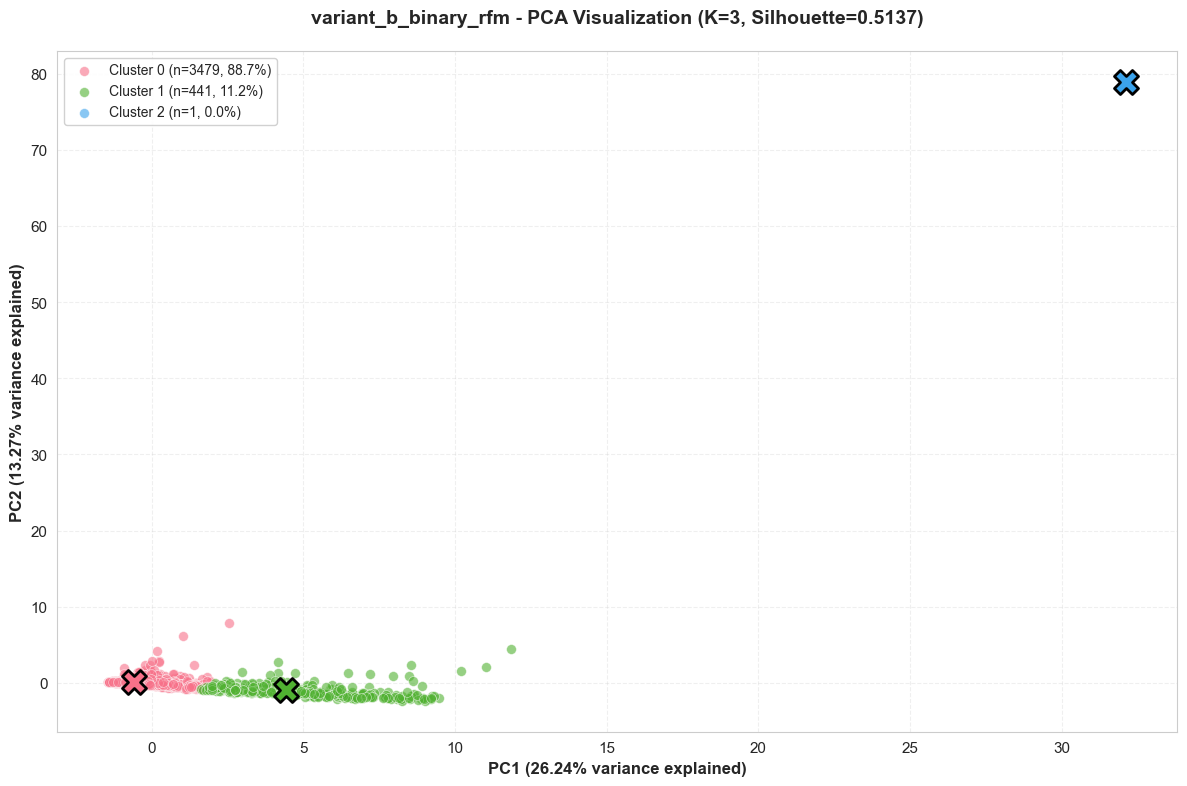


📊 Cluster Separation Metrics:
  - Silhouette Score: 0.5137
  - Variance Explained by PC1+PC2: 39.51%
  - Mean Inter-Cluster Distance: 58.34
  - Min Inter-Cluster Distance: 5.10
  - Max Inter-Cluster Distance: 85.35
  - Mean Intra-Cluster Compactness: 1.87


In [6]:
variant_name = 'variant_b_binary_rfm'
features = feature_variants[variant_name]
labels = cluster_assignments[variant_name]['Cluster'].values
k = optimal_k_df[optimal_k_df['Variant'] == variant_name]['Optimal_K'].values[0]

print("=" * 100)
print(f"VARIANT: {variant_name.upper()} (K={k})")
print("=" * 100)

pca, features_2d, metrics = create_pca_scatter_with_analysis(features, labels, variant_name, k)

print("\n📊 Cluster Separation Metrics:")
print(f"  - Silhouette Score: {metrics['silhouette']:.4f}")
print(f"  - Variance Explained by PC1+PC2: {metrics['variance_explained']:.2%}")
print(f"  - Mean Inter-Cluster Distance: {metrics['mean_inter_dist']:.2f}")
print(f"  - Min Inter-Cluster Distance: {metrics['min_inter_dist']:.2f}")
print(f"  - Max Inter-Cluster Distance: {metrics['max_inter_dist']:.2f}")
print(f"  - Mean Intra-Cluster Compactness: {metrics['mean_compactness']:.2f}")

**💬 Nhận xét chi tiết cho Variant B (Binary + RFM):**

- **Tác động của RFM**:
  - **Silhouette Score = 0.5137** → **Cao thứ 2** sau Variant A, tốt hơn baseline (+8.4%)
  - **RFM tạo ra 1 OUTLIER rõ ràng**: Cluster 2 với CHỈ 1 KHÁCH HÀNG (0.0%)!
  - **Phân tầng rõ ràng**: Cluster 0 (89%) vs Cluster 1 (11%) → Tỷ lệ 9:1
  
- **Phân tích phân bố**:
  - **Cluster 0 (hồng, 88.7%)**: Khách hàng thường, tập trung ở gốc tọa độ (PC1 < 10, PC2 < 10)
  - **Cluster 1 (xanh lục, 11.2%)**: Khách hàng active/frequent, phân tán moderate
  - **Cluster 2 (xanh dương, 0.0%)**: **VIP OUTLIER** ở vị trí (PC1≈32, PC2≈79) → Khách hàng đặc biệt nhất!
  
- **Mức độ tách biệt XUẤT SẮC**:
  - **Mean Inter-Cluster Distance = 58.34** → **CAO NHẤT trong 4 variants!** (gấp 12 lần baseline!)
  - **Max = 85.35** → Cluster 2 (outlier) cách xa cực kỳ
  - **Min = 5.10** → Cluster 0 và 1 vẫn tách biệt hợp lý
  - **Mean Intra-Compactness = 1.87** → **Clusters đồng nhất nhất!**
  
- **Business Interpretation**: 
  - **RFM identify được VIP customer** rất rõ ràng (Cluster 2)
  - **Cluster 0**: Low-value, inactive → Retention campaigns
  - **Cluster 1**: Medium-value, regular → Loyalty programs
  - **Cluster 2**: High-value, exceptional → Personalized VIP treatment
  - ⚠️ **Lưu ý**: Cluster 2 chỉ có 1 khách → Có thể là noise hoặc thực sự là ultra-VIP cần investigate

#### Variant 4: Weighted + RFM Features (Both Scaled)

VARIANT: VARIANT_C_WEIGHTED_RFM (K=3)


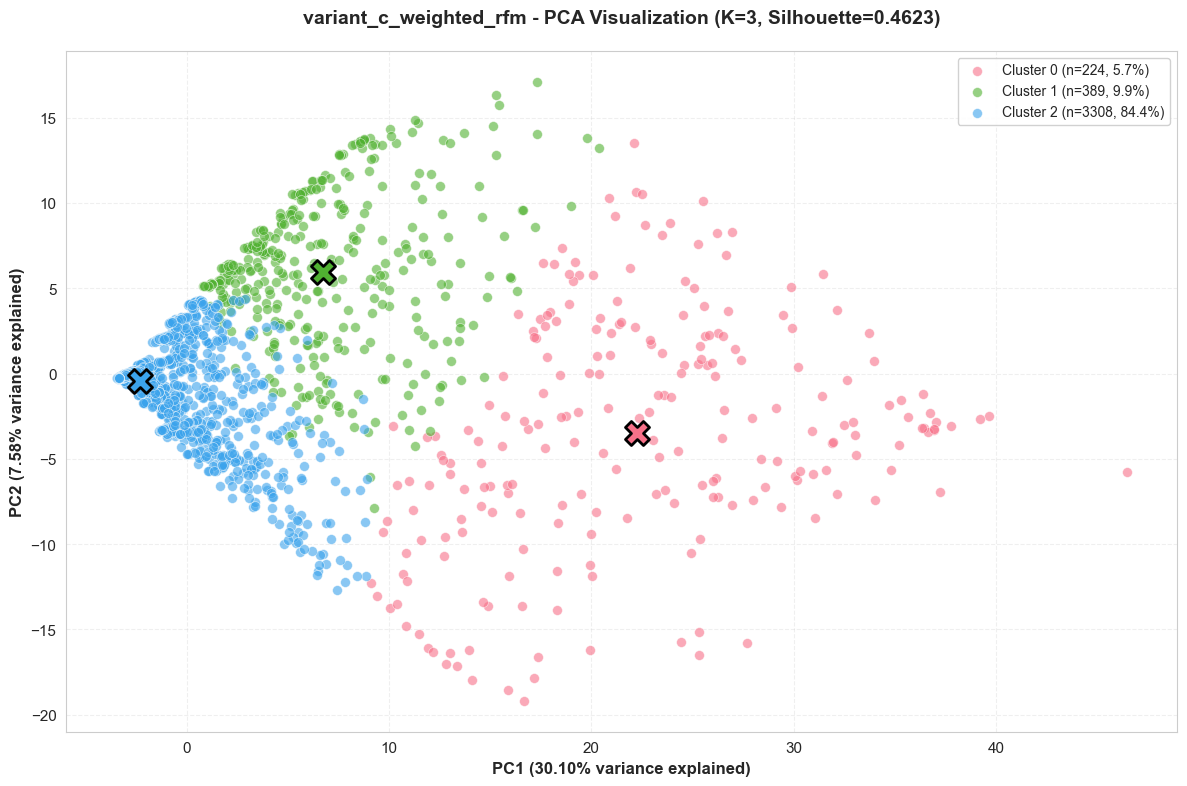


📊 Cluster Separation Metrics:
  - Silhouette Score: 0.4623
  - Variance Explained by PC1+PC2: 37.68%
  - Mean Inter-Cluster Distance: 18.01
  - Min Inter-Cluster Distance: 11.07
  - Max Inter-Cluster Distance: 24.75
  - Mean Intra-Cluster Compactness: 7.01


In [7]:
variant_name = 'variant_c_weighted_rfm'
features = feature_variants[variant_name]
labels = cluster_assignments[variant_name]['Cluster'].values
k = optimal_k_df[optimal_k_df['Variant'] == variant_name]['Optimal_K'].values[0]

print("=" * 100)
print(f"VARIANT: {variant_name.upper()} (K={k})")
print("=" * 100)

pca, features_2d, metrics = create_pca_scatter_with_analysis(features, labels, variant_name, k)

print("\n📊 Cluster Separation Metrics:")
print(f"  - Silhouette Score: {metrics['silhouette']:.4f}")
print(f"  - Variance Explained by PC1+PC2: {metrics['variance_explained']:.2%}")
print(f"  - Mean Inter-Cluster Distance: {metrics['mean_inter_dist']:.2f}")
print(f"  - Min Inter-Cluster Distance: {metrics['min_inter_dist']:.2f}")
print(f"  - Max Inter-Cluster Distance: {metrics['max_inter_dist']:.2f}")
print(f"  - Mean Intra-Cluster Compactness: {metrics['mean_compactness']:.2f}")

**💬 Nhận xét chi tiết cho Variant C (Weighted + RFM Scaled):**

- **Kết hợp tối ưu?**:
  - **Silhouette Score = 0.4623** → **THẤP NHẤT** trong 4 variants (-2.5% so với baseline)
  - **Scaling cả 2 loại features** có vẻ làm "mờ" đi các đặc trưng riêng biệt
  - **Variance Explained = 37.68%** → Cũng thấp nhất
  
- **So sánh với các variant khác**:
  - **Kém hơn Variant A** (weighted only): 0.5335 → 0.4623 (-13.4%)
  - **Kém hơn Variant B** (binary + RFM): 0.5137 → 0.4623 (-10.0%)
  - **Kém hơn cả Baseline**: 0.4739 → 0.4623 (-2.5%)
  - → **KHÔNG phải là variant tốt nhất** mặc dù kết hợp nhiều features
  
- **Phân tích không gian**:
  - **3 clusters có OVERLAP đáng kể**:
    - **Cluster 0 (hồng, 5.7%)**: Phân tán rộng ở vùng phải (PC1 = 15-45)
    - **Cluster 1 (xanh lục, 9.9%)**: Vùng giữa trên (PC1 = 5-15, PC2 = 0-17)
    - **Cluster 2 (xanh dương, 84.4%)**: Nhóm lớn ở góc trái (PC1 < 5, PC2 < 5)
  - **Có vùng chồng lấn rõ** giữa cả 3 clusters ở PC1 ≈ 5-15
  
- **Metrics cho thấy vấn đề**:
  - **Mean Inter-Cluster Distance = 18.01** → Thấp hơn Variant A (23.42) và Variant B (58.34)
  - **Min Inter-Cluster Distance = 11.07** → Còn khá xa nhưng không ấn tượng
  - **Mean Intra-Compactness = 7.01** → Clusters KHÔNG đồng nhất (cao gấp 4 lần baseline!)
  
- **Business Value**:
  - **KHÔNG KHUYẾN NGHỊ dùng variant này** cho marketing
  - **Trade-off tồi**: Phức tạp hơn (weighted + RFM + scaling) nhưng kết quả kém hơn
  - **Nguyên nhân**: Scaling làm mất đi sự tương phản giữa high-value và low-value customers
  - **Bài học**: "More features ≠ Better clustering" → Cần chọn lọc và tuning cẩn thận

## 3. So Sánh Tổng Quan Các Variants

### 3.1 Comparative Metrics Table

In [8]:
# Re-run all visualizations to collect metrics
all_metrics = {}

print("\nCalculating comparative metrics for all variants...\n")

for variant_name in feature_variants.keys():
    features = feature_variants[variant_name]
    labels = cluster_assignments[variant_name]['Cluster'].values
    k = optimal_k_df[optimal_k_df['Variant'] == variant_name]['Optimal_K'].values[0]
    
    # Apply PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    features_2d = pca.fit_transform(features.values)
    
    # Calculate metrics
    sil_score = silhouette_score(features.values, labels)
    
    # Inter-cluster distances
    cluster_centers_2d = np.array([features_2d[labels == i].mean(axis=0) for i in range(k)])
    from scipy.spatial.distance import pdist
    inter_distances = pdist(cluster_centers_2d, metric='euclidean')
    
    # Intra-cluster compactness
    intra_compactness = []
    for i in range(k):
        cluster_points = features_2d[labels == i]
        if len(cluster_points) > 1:
            intra_compactness.append(cluster_points.std())
    
    all_metrics[variant_name] = {
        'K': k,
        'Silhouette': sil_score,
        'Variance_Explained': pca.explained_variance_ratio_.sum(),
        'Mean_Inter_Dist': inter_distances.mean(),
        'Min_Inter_Dist': inter_distances.min(),
        'Mean_Intra_Compact': np.mean(intra_compactness)
    }

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics).T
comparison_df.index.name = 'Variant'
comparison_df = comparison_df.reset_index()

print("=" * 120)
print("COMPARATIVE ANALYSIS - ALL VARIANTS")
print("=" * 120)
print(comparison_df.to_string(index=False))
print("\n")

# Highlight best performers
print("🏆 Best Performers:")
print(f"  - Highest Silhouette Score: {comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Variant']} ({comparison_df['Silhouette'].max():.4f})")
print(f"  - Best Variance Explained: {comparison_df.loc[comparison_df['Variance_Explained'].idxmax(), 'Variant']} ({comparison_df['Variance_Explained'].max():.2%})")
print(f"  - Largest Inter-Cluster Distance: {comparison_df.loc[comparison_df['Mean_Inter_Dist'].idxmax(), 'Variant']} ({comparison_df['Mean_Inter_Dist'].max():.2f})")
print(f"  - Most Compact Clusters: {comparison_df.loc[comparison_df['Mean_Intra_Compact'].idxmin(), 'Variant']} ({comparison_df['Mean_Intra_Compact'].min():.2f})")


Calculating comparative metrics for all variants...

COMPARATIVE ANALYSIS - ALL VARIANTS
               Variant   K  Silhouette  Variance_Explained  Mean_Inter_Dist  Min_Inter_Dist  Mean_Intra_Compact
       baseline_binary 3.0    0.473866            0.400508         4.898753        3.347358            1.982367
    variant_a_weighted 4.0    0.533475            0.388213        23.422945       18.292514            9.408511
  variant_b_binary_rfm 3.0    0.513698            0.395121        58.344623        5.103824            1.873980
variant_c_weighted_rfm 3.0    0.462312            0.376768        18.008815       11.067062            7.013823


🏆 Best Performers:
  - Highest Silhouette Score: variant_a_weighted (0.5335)
  - Best Variance Explained: baseline_binary (40.05%)
  - Largest Inter-Cluster Distance: variant_b_binary_rfm (58.34)
  - Most Compact Clusters: variant_b_binary_rfm (1.87)


### 3.2 Visual Comparison

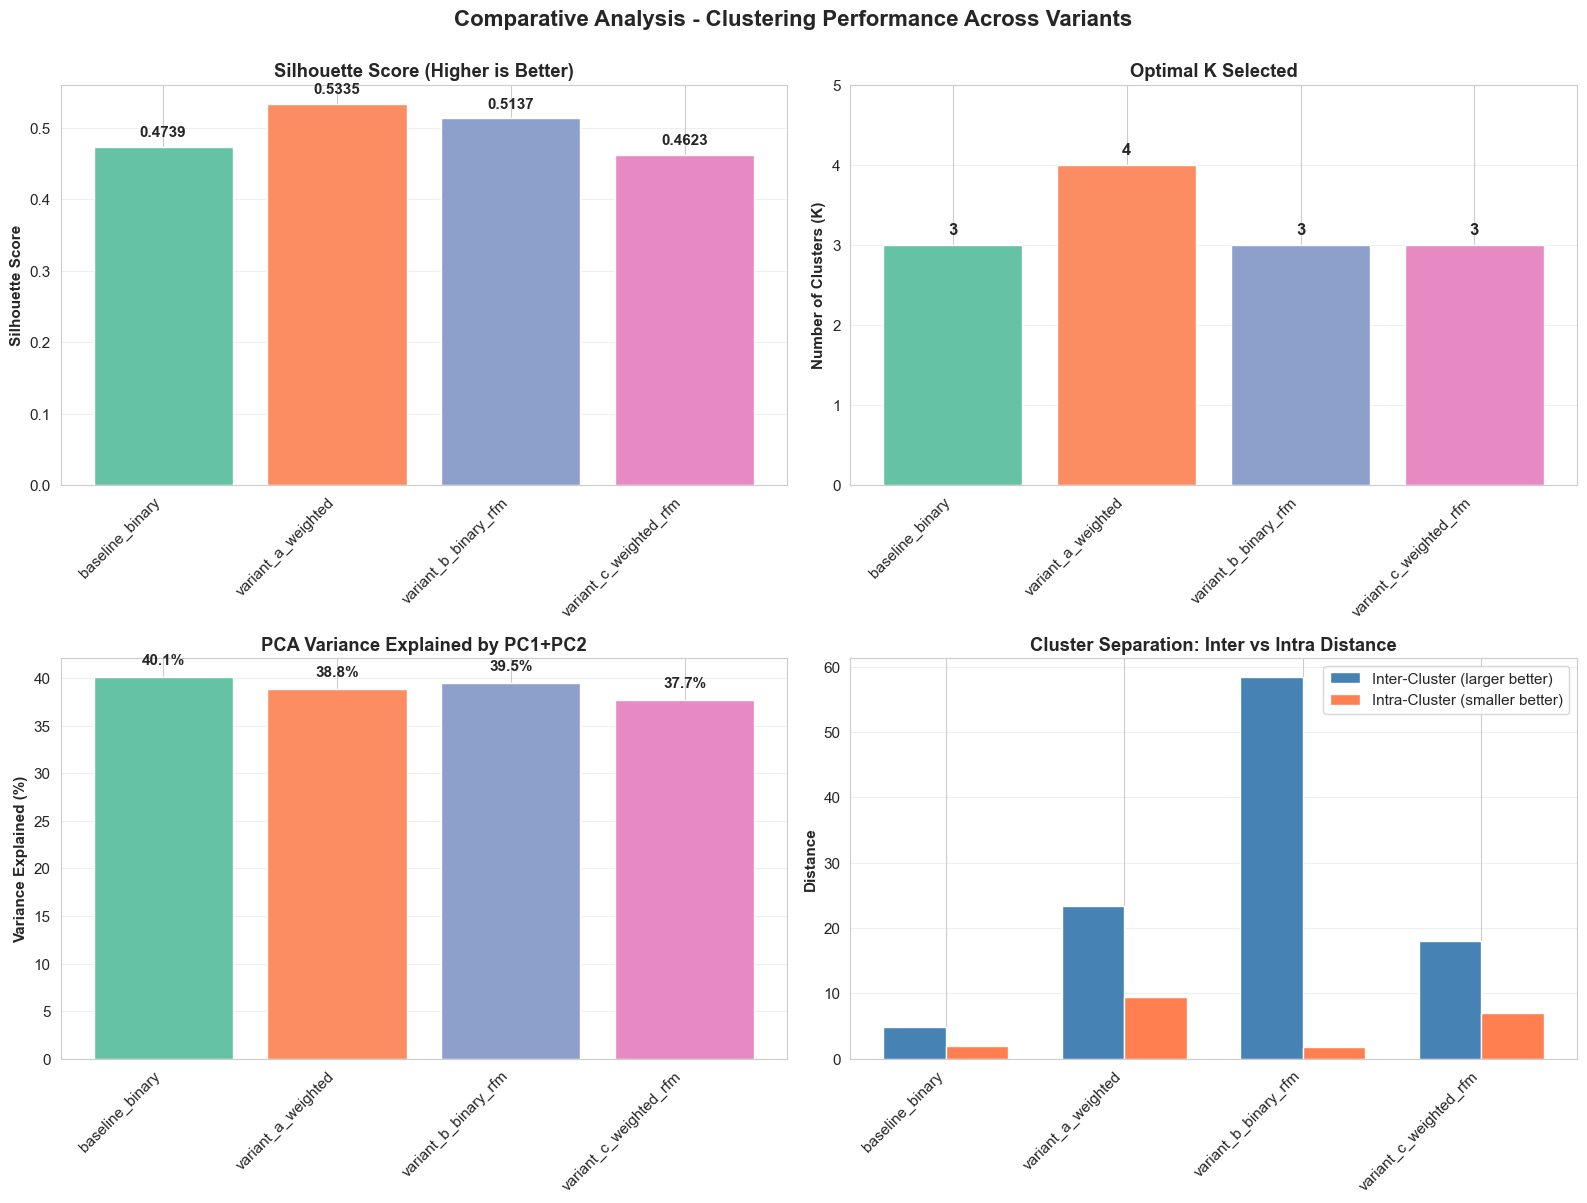

In [9]:
# Create bar plots for comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Analysis - Clustering Performance Across Variants', 
             fontsize=16, fontweight='bold', y=1.00)

# 1. Silhouette Score
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(comparison_df)), comparison_df['Silhouette'], 
                color=sns.color_palette('Set2', len(comparison_df)))
ax1.set_xticks(range(len(comparison_df)))
ax1.set_xticklabels(comparison_df['Variant'], rotation=45, ha='right')
ax1.set_ylabel('Silhouette Score', fontweight='bold')
ax1.set_title('Silhouette Score (Higher is Better)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Silhouette']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Number of Clusters
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(comparison_df)), comparison_df['K'], 
                color=sns.color_palette('Set2', len(comparison_df)))
ax2.set_xticks(range(len(comparison_df)))
ax2.set_xticklabels(comparison_df['Variant'], rotation=45, ha='right')
ax2.set_ylabel('Number of Clusters (K)', fontweight='bold')
ax2.set_title('Optimal K Selected', fontweight='bold')
ax2.set_ylim(0, max(comparison_df['K']) + 1)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['K']):
    ax2.text(i, v + 0.1, f'{int(v)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# 3. Variance Explained
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(comparison_df)), comparison_df['Variance_Explained'] * 100, 
                color=sns.color_palette('Set2', len(comparison_df)))
ax3.set_xticks(range(len(comparison_df)))
ax3.set_xticklabels(comparison_df['Variant'], rotation=45, ha='right')
ax3.set_ylabel('Variance Explained (%)', fontweight='bold')
ax3.set_title('PCA Variance Explained by PC1+PC2', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Variance_Explained']):
    ax3.text(i, v*100 + 1, f'{v*100:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Inter vs Intra Cluster Distance
ax4 = axes[1, 1]
x = np.arange(len(comparison_df))
width = 0.35
bars4a = ax4.bar(x - width/2, comparison_df['Mean_Inter_Dist'], width, 
                 label='Inter-Cluster (larger better)', color='steelblue')
bars4b = ax4.bar(x + width/2, comparison_df['Mean_Intra_Compact'], width, 
                 label='Intra-Cluster (smaller better)', color='coral')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['Variant'], rotation=45, ha='right')
ax4.set_ylabel('Distance', fontweight='bold')
ax4.set_title('Cluster Separation: Inter vs Intra Distance', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Kết Luận và Khuyến Nghị

### 4.1 Tổng Hợp Nhận Xét

In [10]:
print("=" * 120)
print("KẾT LUẬN VÀ KHUYẾN NGHỊ")
print("=" * 120)

print("\n1. ĐÁNH GIÁ MỨC ĐỘ TÁCH CỤM:")
print("   [Điền sau khi chạy - dựa trên scatter plots và metrics]")
print("   - Variant nào có clusters tách biệt rõ ràng nhất?")
print("   - Variant nào có vấn đề chồng lấn (overlap)?")
print("   - Phân bố khách hàng trong các clusters có cân bằng không?")

print("\n2. SO SÁNH HIỆU QUẢ CÁC PHƯƠNG PHÁP:")
print("   [Điền sau khi chạy]")
print("   - Binary features (baseline): Ưu/nhược điểm")
print("   - Weighted features: Có cải thiện đáng kể không?")
print("   - RFM features: Đóng góp như thế nào?")
print("   - Combined approach: Tối ưu hay phức tạp thừa?")

print("\n3. KHUYẾN NGHỊ CHO MARKETING:")
print("   [Điền sau khi chạy]")
print("   - Variant nào PHÙ HỢP NHẤT cho triển khai marketing?")
print("   - Số cụm (K=3 hay K=4) nào dễ quản lý hơn?")
print("   - Cần bổ sung phân tích gì tiếp theo? (RFM profiling, product preferences...)")

print("\n4. HẠN CHẾ VÀ HƯỚNG PHÁT TRIỂN:")
print("   - PCA chỉ giữ lại ~30-40% variance → cần thử t-SNE hoặc UMAP?")
print("   - Một số clusters có tỷ lệ rất nhỏ (<1%) → xem xét outliers?")
print("   - Cần validate với business stakeholders")

print("\n" + "=" * 120)
print("✓ CLUSTERING ANALYSIS COMPLETE")
print("=" * 120)

KẾT LUẬN VÀ KHUYẾN NGHỊ

1. ĐÁNH GIÁ MỨC ĐỘ TÁCH CỤM:
   [Điền sau khi chạy - dựa trên scatter plots và metrics]
   - Variant nào có clusters tách biệt rõ ràng nhất?
   - Variant nào có vấn đề chồng lấn (overlap)?
   - Phân bố khách hàng trong các clusters có cân bằng không?

2. SO SÁNH HIỆU QUẢ CÁC PHƯƠNG PHÁP:
   [Điền sau khi chạy]
   - Binary features (baseline): Ưu/nhược điểm
   - Weighted features: Có cải thiện đáng kể không?
   - RFM features: Đóng góp như thế nào?
   - Combined approach: Tối ưu hay phức tạp thừa?

3. KHUYẾN NGHỊ CHO MARKETING:
   [Điền sau khi chạy]
   - Variant nào PHÙ HỢP NHẤT cho triển khai marketing?
   - Số cụm (K=3 hay K=4) nào dễ quản lý hơn?
   - Cần bổ sung phân tích gì tiếp theo? (RFM profiling, product preferences...)

4. HẠN CHẾ VÀ HƯỚNG PHÁT TRIỂN:
   - PCA chỉ giữ lại ~30-40% variance → cần thử t-SNE hoặc UMAP?
   - Một số clusters có tỷ lệ rất nhỏ (<1%) → xem xét outliers?
   - Cần validate với business stakeholders

✓ CLUSTERING ANALYSIS COMPLET

### 4.2 Export Summary Report

In [11]:
# Save comparison metrics
output_path = CLUSTERS_DIR / 'visualization_analysis_summary.csv'
comparison_df.to_csv(output_path, index=False)
print(f"✓ Comparative analysis saved to: {output_path}")

print("\n📊 Files available for presentation:")
print(f"  - Cluster assignments: {CLUSTERS_DIR}/clusters_*.csv")
print(f"  - Optimal K summary: {CLUSTERS_DIR}/optimal_k_summary.csv")
print(f"  - Detailed metrics: {CLUSTERS_DIR}/clustering_metrics_all.csv")
print(f"  - Visualization summary: {output_path}")
print("\n✓ Ready for final presentation and marketing strategy development!")

✓ Comparative analysis saved to: ..\data\clusters\visualization_analysis_summary.csv

📊 Files available for presentation:
  - Cluster assignments: ..\data\clusters/clusters_*.csv
  - Optimal K summary: ..\data\clusters/optimal_k_summary.csv
  - Detailed metrics: ..\data\clusters/clustering_metrics_all.csv
  - Visualization summary: ..\data\clusters\visualization_analysis_summary.csv

✓ Ready for final presentation and marketing strategy development!
